In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score  
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import xarray as xr
import numpy as np
import joblib
from imblearn.ensemble import BalancedRandomForestClassifier

import helper
from helper import plot_confusion_matrix, print_classification_report

# from dask.distributed import Client, progress
# client = Client(processes=False, threads_per_worker=1,
#                 n_workers=40, memory_limit='2.5GB', dashboard_address=':8787')
# client



In [23]:
data = xr.open_dataset('../data/training_flat_corrected.nc')
data

<xarray.Dataset>
Dimensions:      (z: 20282535)
Coordinates:
  * z            (z) int64 0 1 2 3 4 ... 20282531 20282532 20282533 20282534
Data variables:
    y            (z) float64 ...
    X1           (z) float32 ...
    X2           (z) float32 ...
    X3           (z) float32 ...
    X4           (z) float32 ...
    X5           (z) float32 ...
    X6           (z) float64 ...
    X7           (z) float64 ...
    X8           (z) float64 ...
    group        (z) int64 ...
    sample       (z) datetime64[ns] ...
    y_corrected  (z) float64 ...

In [24]:
samples = np.unique(data.sample)


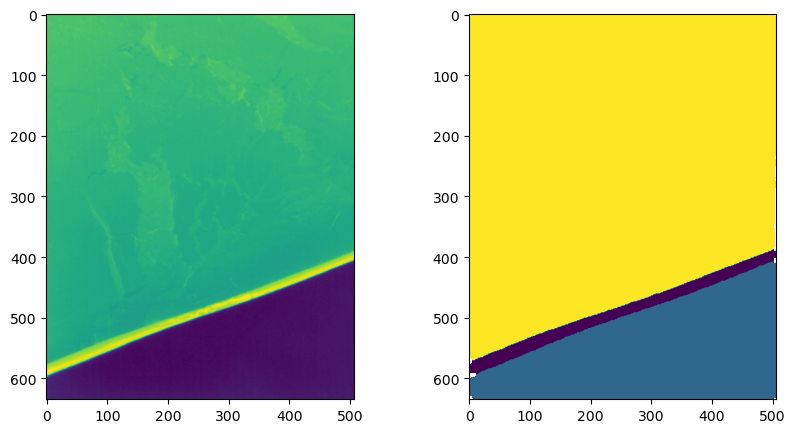

In [25]:
mask = data.sample == samples[0]
test= data.isel(z=mask)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test.X1.values.reshape(635, 507))
ax[1].imshow(test.y.values.reshape(635, 507))
# okay, the images can be reproduced from the data, so we can use the data to train a model

Classes: ['1.0 (1.47%)', '2.0 (21.56%)', '3.0 (40.67%)', 'nan (36.30%)']
Names: Open-Water (1), Thin Ice (2), Snow-Covered (3)
Total: 20282535


After Filtering NaNs
Classes: ['1.0 (2.33%)', '2.0 (34.27%)', '3.0 (63.39%)']
Names: Open-Water (1), Thin Ice (2), Snow-Covered (3)
Total: 12760624


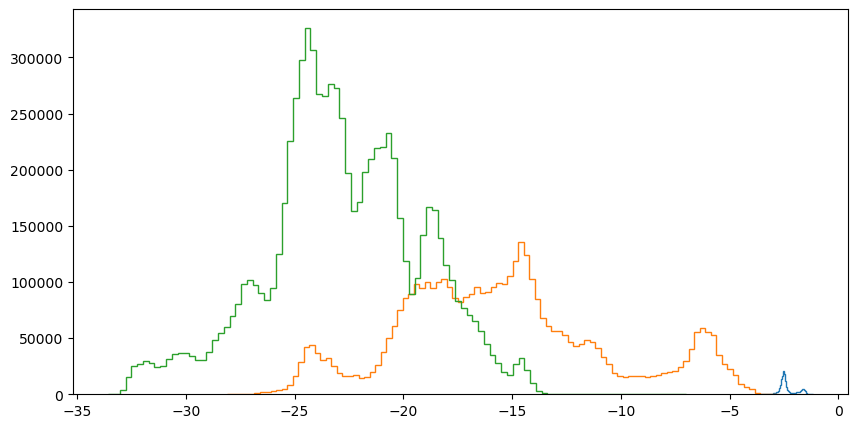

In [26]:
unique, count = np.unique(data['y_corrected'], return_counts=True)

print('Classes:', [f'{u} ({c / count.sum() * 100:.2f}%)' for u, c in zip(unique, count)])
print('Names:', 'Open-Water (1), Thin Ice (2), Snow-Covered (3)')
print('Total:', count.sum())
#

X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].to_array().values.T
y = data['y_corrected'].values

mask = np.isnan(X).any(axis=1) | np.isnan(y) 
X = X[~mask]
y = y[~mask]

unique, count = np.unique(y, return_counts=True)

print('After Filtering NaNs')
print('Classes:', [f'{u} ({c / count.sum() * 100:.2f}%)' for u, c in zip(unique, count)])
print('Names:', 'Open-Water (1), Thin Ice (2), Snow-Covered (3)')
print('Total:', count.sum())
#

# plot the distribution of the classes

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.hist(X[y==1, 0], bins=100, label='Open-Water', histtype='step')
plt.hist(X[y==2, 0], bins=100, label='Thin Ice', histtype='step')
plt.hist(X[y==3, 0], bins=100, label='Snow-Covered', histtype='step')
plt.show()

RESAMPLING
Classes: ['1.0 (33.33%)', '2.0 (33.33%)', '3.0 (33.33%)']
Names: Open-Water (1), Thin Ice (2), Snow-Covered (3)
Total: 893871


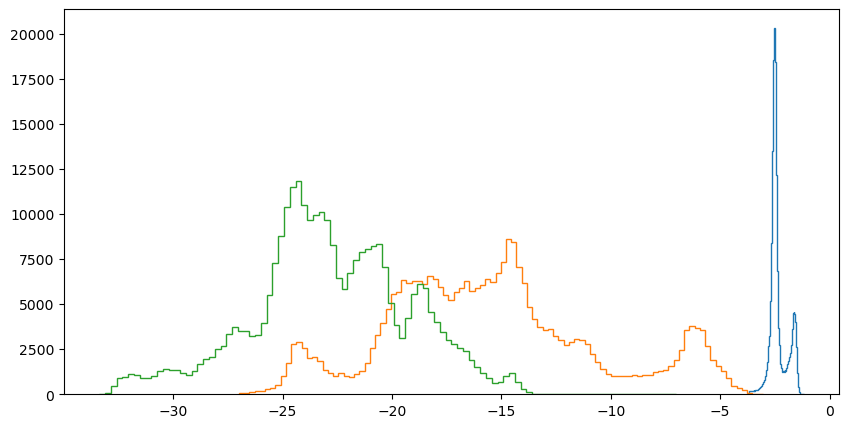

In [27]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X, y)

unique, count = np.unique(y_resampled, return_counts=True)

print('RESAMPLING')

print('Classes:', [f'{u} ({c / count.sum() * 100:.2f}%)' for u, c in zip(unique, count)])
print('Names:', 'Open-Water (1), Thin Ice (2), Snow-Covered (3)')
print('Total:', count.sum())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.hist(X_resampled[y_resampled==1, 0], bins=100, label='Open-Water', histtype='step')
plt.hist(X_resampled[y_resampled==2, 0], bins=100, label='Thin Ice', histtype='step')
plt.hist(X_resampled[y_resampled==3, 0], bins=100, label='Snow-Covered', histtype='step')
plt.show()

In [28]:
# make sure no NaNs are left

print('NaNs in X:', sum(sum(sum([np.isnan(X)]))))
print('NaNs in y:', sum(np.isnan(y)))

clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=50, 
                             bootstrap=True,
                             n_jobs=48)

bclf = BalancedRandomForestClassifier(n_estimators=10, 
                                      random_state=0, 
                                      sampling_strategy='all', # 'not minority', 'not majority', 'all', 'majority', 'minority', 'not minority', 'auto'
                                      replacement=True,
                                      bootstrap=False,
                                        n_jobs=48)

NaNs in X: 0
NaNs in y: 0


In [29]:
y_pred = cross_val_predict(clf, X_resampled, y_resampled, cv=5, verbose=100)
clf.fit(X_resampled, y_resampled)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   14.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   21.7s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   28.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   35.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   35.5s


RandomForestClassifier(max_depth=50, n_jobs=48)

In [30]:
print('Accuracy:', accuracy_score(y_resampled, y_pred))

Accuracy: 0.9198765817438982


In [31]:
def print_classification_report(classification_report):
    """
    Print the classification report in a pretty way.
    
    Parameters:
        classification_report (dict): The classification report.
    """
    print(f"{'Label':<20} {'Precision':<20} {'Recall':<20} {'F1-score':<20}")
    for label, metrics in classification_report.items():
        if label == 'accuracy': 
            print('accuracy_score:' , metrics)
            print('\n')

        else:
            print(f"{label:<20} {metrics['precision']:<20} {metrics['recall']:<20} {metrics['f1-score']:<20}")
            print('-'*80)

    # plot the confusion matrix in a pretty way

def plot_confusion_matrix(confusion_matrix):

    plt.figure(figsize=(6, 4))
    plt.imshow(confusion_matrix, cmap='Reds', )
    plt.title('Confusion matrix')
    plt.colorbar(label='Total number of samples')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0, 1, 2], ['Open Water', 'Thin Ice', 'Snow-covered Sea Ice'], rotation=45)
    plt.yticks([0, 1, 2], ['Open Water', 'Thin Ice', 'Snow-covered Sea Ice'], rotation=45)

    # plot the percentage of the confusion matrix into the figure

    
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, f'{confusion_matrix[i, j]:.4f}',
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > .9 else "black")



Label                Precision            Recall               F1-score            
1.0                  0.9998288636546669   1.0                  0.9999144245047947  
--------------------------------------------------------------------------------
2.0                  0.891441576993985    0.864963736378068    0.8780030797323631  
--------------------------------------------------------------------------------
3.0                  0.8690033772770541   0.8946660088536266   0.8816479883845725  
--------------------------------------------------------------------------------
accuracy_score: 0.9198765817438982


macro avg            0.920091272641902    0.9198765817438982   0.9198551642072434  
--------------------------------------------------------------------------------
weighted avg         0.920091272641902    0.9198765817438982   0.9198551642072433  
--------------------------------------------------------------------------------


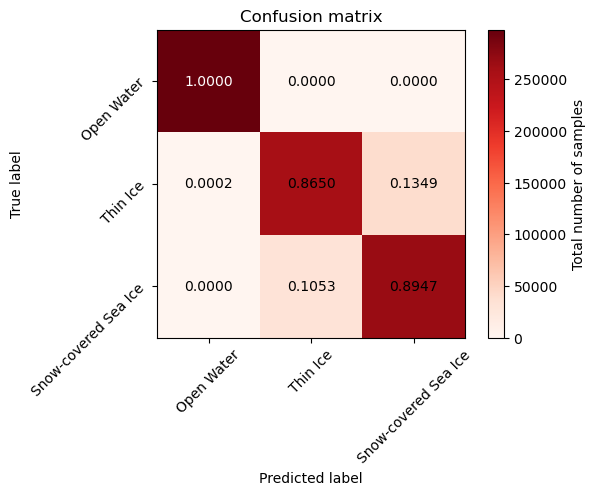

In [32]:
cm = confusion_matrix(y_resampled, y_pred)
plot_confusion_matrix(cm)
print_classification_report(classification_report(y_resampled, y_pred, output_dict=True))

Label                Precision            Recall               F1-score            
1.0                  0.9976528336759772   1.0                  0.9988250379222782  
--------------------------------------------------------------------------------
2.0                  0.8222670617433331   0.8751529436405971   0.84788612984518    
--------------------------------------------------------------------------------
3.0                  0.9301557431453624   0.8977318747524515   0.9136562345840317  
--------------------------------------------------------------------------------
accuracy_score: 0.8923815167659512


macro avg            0.9166918795215576   0.9242949394643496   0.9201224674504966  
--------------------------------------------------------------------------------
weighted avg         0.8947559869120023   0.8923815167659512   0.8931040589198423  
--------------------------------------------------------------------------------


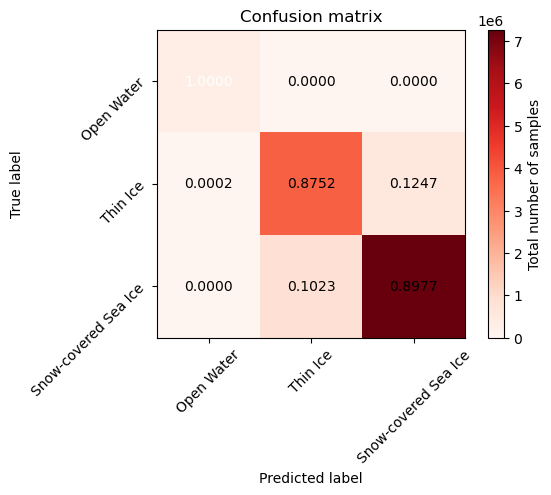

In [33]:
# now, let's predict on the full dataset and see how well our classifier performs

y_pred = clf.predict(X)

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm)
print_classification_report(classification_report(y, y_pred, output_dict=True))